In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2024-09-10 06:08:25.277338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 06:08:25.277791: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 06:08:25.279806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 06:08:25.454150: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install --upgrade matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 20.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 31.1 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.12.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
dask-cudf 23.12.0 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.
numba 0.57.1+1.gb7ee25572 requires numpy<1.25,>=1.21, but you have numpy 1.26.4 which is incompatible.


In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

In [4]:
train_df = pd.read_csv('../newKDDTrain+.txt', header=None)

columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
train_df.columns = columns

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
test_df = pd.read_csv('../newKDDTest+.txt', header=None)

test_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
test_df.columns = columns

test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


In [6]:
df = pd.concat([train_df, test_df])

In [7]:
df['class']

0         normal
1         normal
2        anomaly
3         normal
4         normal
          ...   
22539     normal
22540     normal
22541    anomaly
22542     normal
22543    anomaly
Name: class, Length: 148517, dtype: object

In [8]:
df.isnull().values.any()

False

In [9]:
len(df.columns)

42

In [10]:
df.shape

(148517, 42)

In [11]:
# 'label' 열의 값이 'normal.'이면 0으로, 'normal.'이 아니면 1로 변경
df['class'] = df['class'].apply(lambda x: 0 if x == 'normal' else 1)

# 변경된 데이터프레임 확인
print(df.head())

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   


In [12]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding 적용
label_encoder = LabelEncoder()
df['protocol_type'] = label_encoder.fit_transform(df['protocol_type'])
df['service'] = label_encoder.fit_transform(df['service'])
df['flag'] = label_encoder.fit_transform(df['flag'])

# 인코딩된 데이터프레임 확인
print(df.head())

   duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       20     9        491          0     0   
1         0              2       44     9        146          0     0   
2         0              1       49     5          0          0     0   
3         0              1       24     9        232       8153     0   
4         0              1       24     9        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.

In [13]:
df.shape

(148517, 42)

In [14]:
# 상관계수 계산
corr = df.corr()

# 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt='.1f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:69: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.zeros(data.shape, np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

<Figure size 1600x1200 with 0 Axes>

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((133665, 42), (14852, 42))

In [16]:
X_train_normal = X_train[X_train['class'] == 0]
X_train_normal.shape

X_test_normal = X_test[X_test['class'] == 0]
X_test_normal.shape

(7720, 42)

In [17]:
y_train_normal = X_train_normal['class']
X_train_normal = X_train_normal.drop(labels='class',axis=1)

y_test_normal = X_test_normal['class']
X_test_normal = X_test_normal.drop(labels='class',axis=1)

In [18]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
import pandas as pd

# StandardScaler와 PCA 진행은 동일
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(X_train_normal)
#test_X_scaled = scaler.transform(X_test_normal)

# PCA 수행
num_components = 20  # 20개의 주성분 사용
pca = PCA(n_components=num_components)
train_X_pca = pca.fit_transform(train_X_scaled)
#test_X_pca = pca.transform(test_X_scaled)

# SelectKBest로 상위 20개의 특성 선택
feature_selector = SelectKBest(score_func=f_classif, k=20)
train_X_selected = feature_selector.fit_transform(train_X_pca, y_train_normal)
#test_X_selected = feature_selector.transform(test_X_pca)

# 원래 특성 이름 (train_X_scaled.shape[1]에 맞게 조정)
original_feature_names = X_train_normal.columns[:train_X_scaled.shape[1]]

# PCA 주성분에 대한 각 원래 특성의 기여도 (loading)
loading_matrix = pd.DataFrame(pca.components_.T, 
                              columns=[f'PC{i}' for i in range(num_components)], 
                              index=original_feature_names)

# 상위 K개의 주성분이 선택된 특성의 기여도를 확인
selected_pca_features = feature_selector.get_support(indices=True)
selected_pca_loading = loading_matrix.iloc[:, selected_pca_features]

print("PCA Components Loading Matrix for Selected Features:")
print(selected_pca_loading)

PCA Components Loading Matrix for Selected Features:
                                      PC0       PC1           PC2       PC3  \
duration                     2.859301e-02  0.236513 -5.718206e-02  0.109737   
protocol_type               -6.542609e-02 -0.003980 -4.414691e-01  0.094644   
service                      3.368782e-03  0.259821  1.183624e-01 -0.072069   
flag                        -4.300635e-01  0.041851  3.563142e-02 -0.024041   
src_bytes                   -1.692652e-03  0.026132  9.676864e-03  0.014616   
dst_bytes                   -2.591135e-03  0.048885  4.477889e-02  0.108693   
land                         1.013051e-02  0.020485  1.598368e-02  0.004972   
wrong_fragment               6.396075e-05  0.016659 -1.979234e-02 -0.004083   
urgent                       4.354711e-04  0.019575  9.797025e-03  0.037596   
hot                         -8.899410e-03  0.084490  3.658941e-02 -0.053929   
num_failed_logins            4.985247e-03  0.037271  8.650985e-03  0.022504   

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in divide
  msb = ssbn / float(dfbn)


In [19]:
# 선택된 PCA 주성분에 기여한 원래 특성의 column명 가져오기
selected_feature_names = original_feature_names[selected_pca_features]

# 선택된 column명 출력
print("Selected Feature Names:")
print(selected_feature_names)

Selected Feature Names:
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds'],
      dtype='object')


In [20]:
columns_list = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'class']
X_test = X_test[columns_list]

In [21]:
y_test = X_test['class']
X_test = X_test.drop(labels='class', axis=1)

In [22]:
print(train_X_selected)

[[-0.3399013  -0.7575295   0.9291448  ... -0.27369565 -0.058934
   0.0587995 ]
 [-0.82090814 -0.96654418  0.44901521 ...  0.37403436  0.04087548
  -0.14680881]
 [-0.01265626  0.9466393   0.49426614 ... -0.51582099  0.05727763
  -0.46035478]
 ...
 [-0.71092749  0.30936919  1.22556709 ...  0.386825   -0.27155879
   0.69515305]
 [-0.67190978  1.09887059  0.72240594 ... -0.12887997  0.08624912
  -0.46318901]
 [-1.15175172 -1.71203177 -4.20675302 ... -0.21478767 -0.03009209
   0.23124226]]


In [23]:
train_X_selected.shape

(69334, 20)

In [24]:
!pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for keras_self_attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=055b38773ee83f338b0bbc399c8bcac92af78f0a857ddcde40e8cbd3fe8a9029
  Stored in directory: /home/work/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras_self_attention


In [25]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=10, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(train_X_selected, y_train_normal)
model.summary()

# Compile and train the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model.fit([train_X_selected, y_train_normal], train_X_selected,
                    shuffle=True,
                    epochs=100, 
                    validation_split=0.1,  
                    batch_size=32).history  

2024-09-10 06:29:33.124456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0
2024-09-10 06:29:33.127306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 20)                200       ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 20)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 20)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

2024-09-10 06:29:36.213409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-09-10 06:29:37.246141: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efb4a6e9f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-10 06:29:37.246202: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-09-10 06:29:37.246210: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-09-10 06:29:37.253986: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 06:29:37.344880: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1950/1950 [==============================] - 17s 6ms/step - loss: 57213.7266 - accuracy: 0.7369 - val_loss: 3.9810 - val_accuracy: 0.8248
Epoch 2/100
1950/1950 [==============================] - 12s 6ms/step - loss: 9.7792 - accuracy: 0.8111 - val_loss: 2.4694 - val_accuracy: 0.8385
Epoch 3/100
1950/1950 [==============================] - 12s 6ms/step - loss: 7.2184 - accuracy: 0.8306 - val_loss: 2.8668 - val_accuracy: 0.7662
Epoch 4/100
1950/1950 [==============================] - 11s 6ms/step - loss: 4.8135 - accuracy: 0.8419 - val_loss: 2.0576 - val_accuracy: 0.8189
Epoch 5/100
1950/1950 [==============================] - 15s 8ms/step - loss: 6.3510 - accuracy: 0.8423 - val_loss: 1.7042 - val_accuracy: 0.8013
Epoch 6/100
1950/1950 [==============================] - 15s 8ms/step - loss: 12.4017 - accuracy: 0.8675 - val_loss: 2.2996 - val_accuracy: 0.8176
Epoch 7/100
1950/1950 [==============================] - 15s 8ms/step - loss: 3.9350 - accuracy: 0.8675 - val_loss: 0.9671 - val_ac

Epoch 57/100
1950/1950 [==============================] - 15s 8ms/step - loss: 1.5421 - accuracy: 0.9219 - val_loss: 0.4079 - val_accuracy: 0.9345
Epoch 58/100
1950/1950 [==============================] - 15s 8ms/step - loss: 4.8222 - accuracy: 0.9155 - val_loss: 0.4111 - val_accuracy: 0.9142
Epoch 59/100
1950/1950 [==============================] - 15s 8ms/step - loss: 1.9515 - accuracy: 0.9294 - val_loss: 0.4272 - val_accuracy: 0.8969
Epoch 60/100
1950/1950 [==============================] - 15s 8ms/step - loss: 1.1967 - accuracy: 0.9290 - val_loss: 0.2308 - val_accuracy: 0.9426
Epoch 61/100
1950/1950 [==============================] - 15s 8ms/step - loss: 1.3377 - accuracy: 0.9308 - val_loss: 0.6140 - val_accuracy: 0.9169
Epoch 62/100
1950/1950 [==============================] - 14s 7ms/step - loss: 1.7619 - accuracy: 0.9276 - val_loss: 0.4033 - val_accuracy: 0.9250
Epoch 63/100
1950/1950 [==============================] - 16s 8ms/step - loss: 0.9827 - accuracy: 0.9171 - val_loss: 0

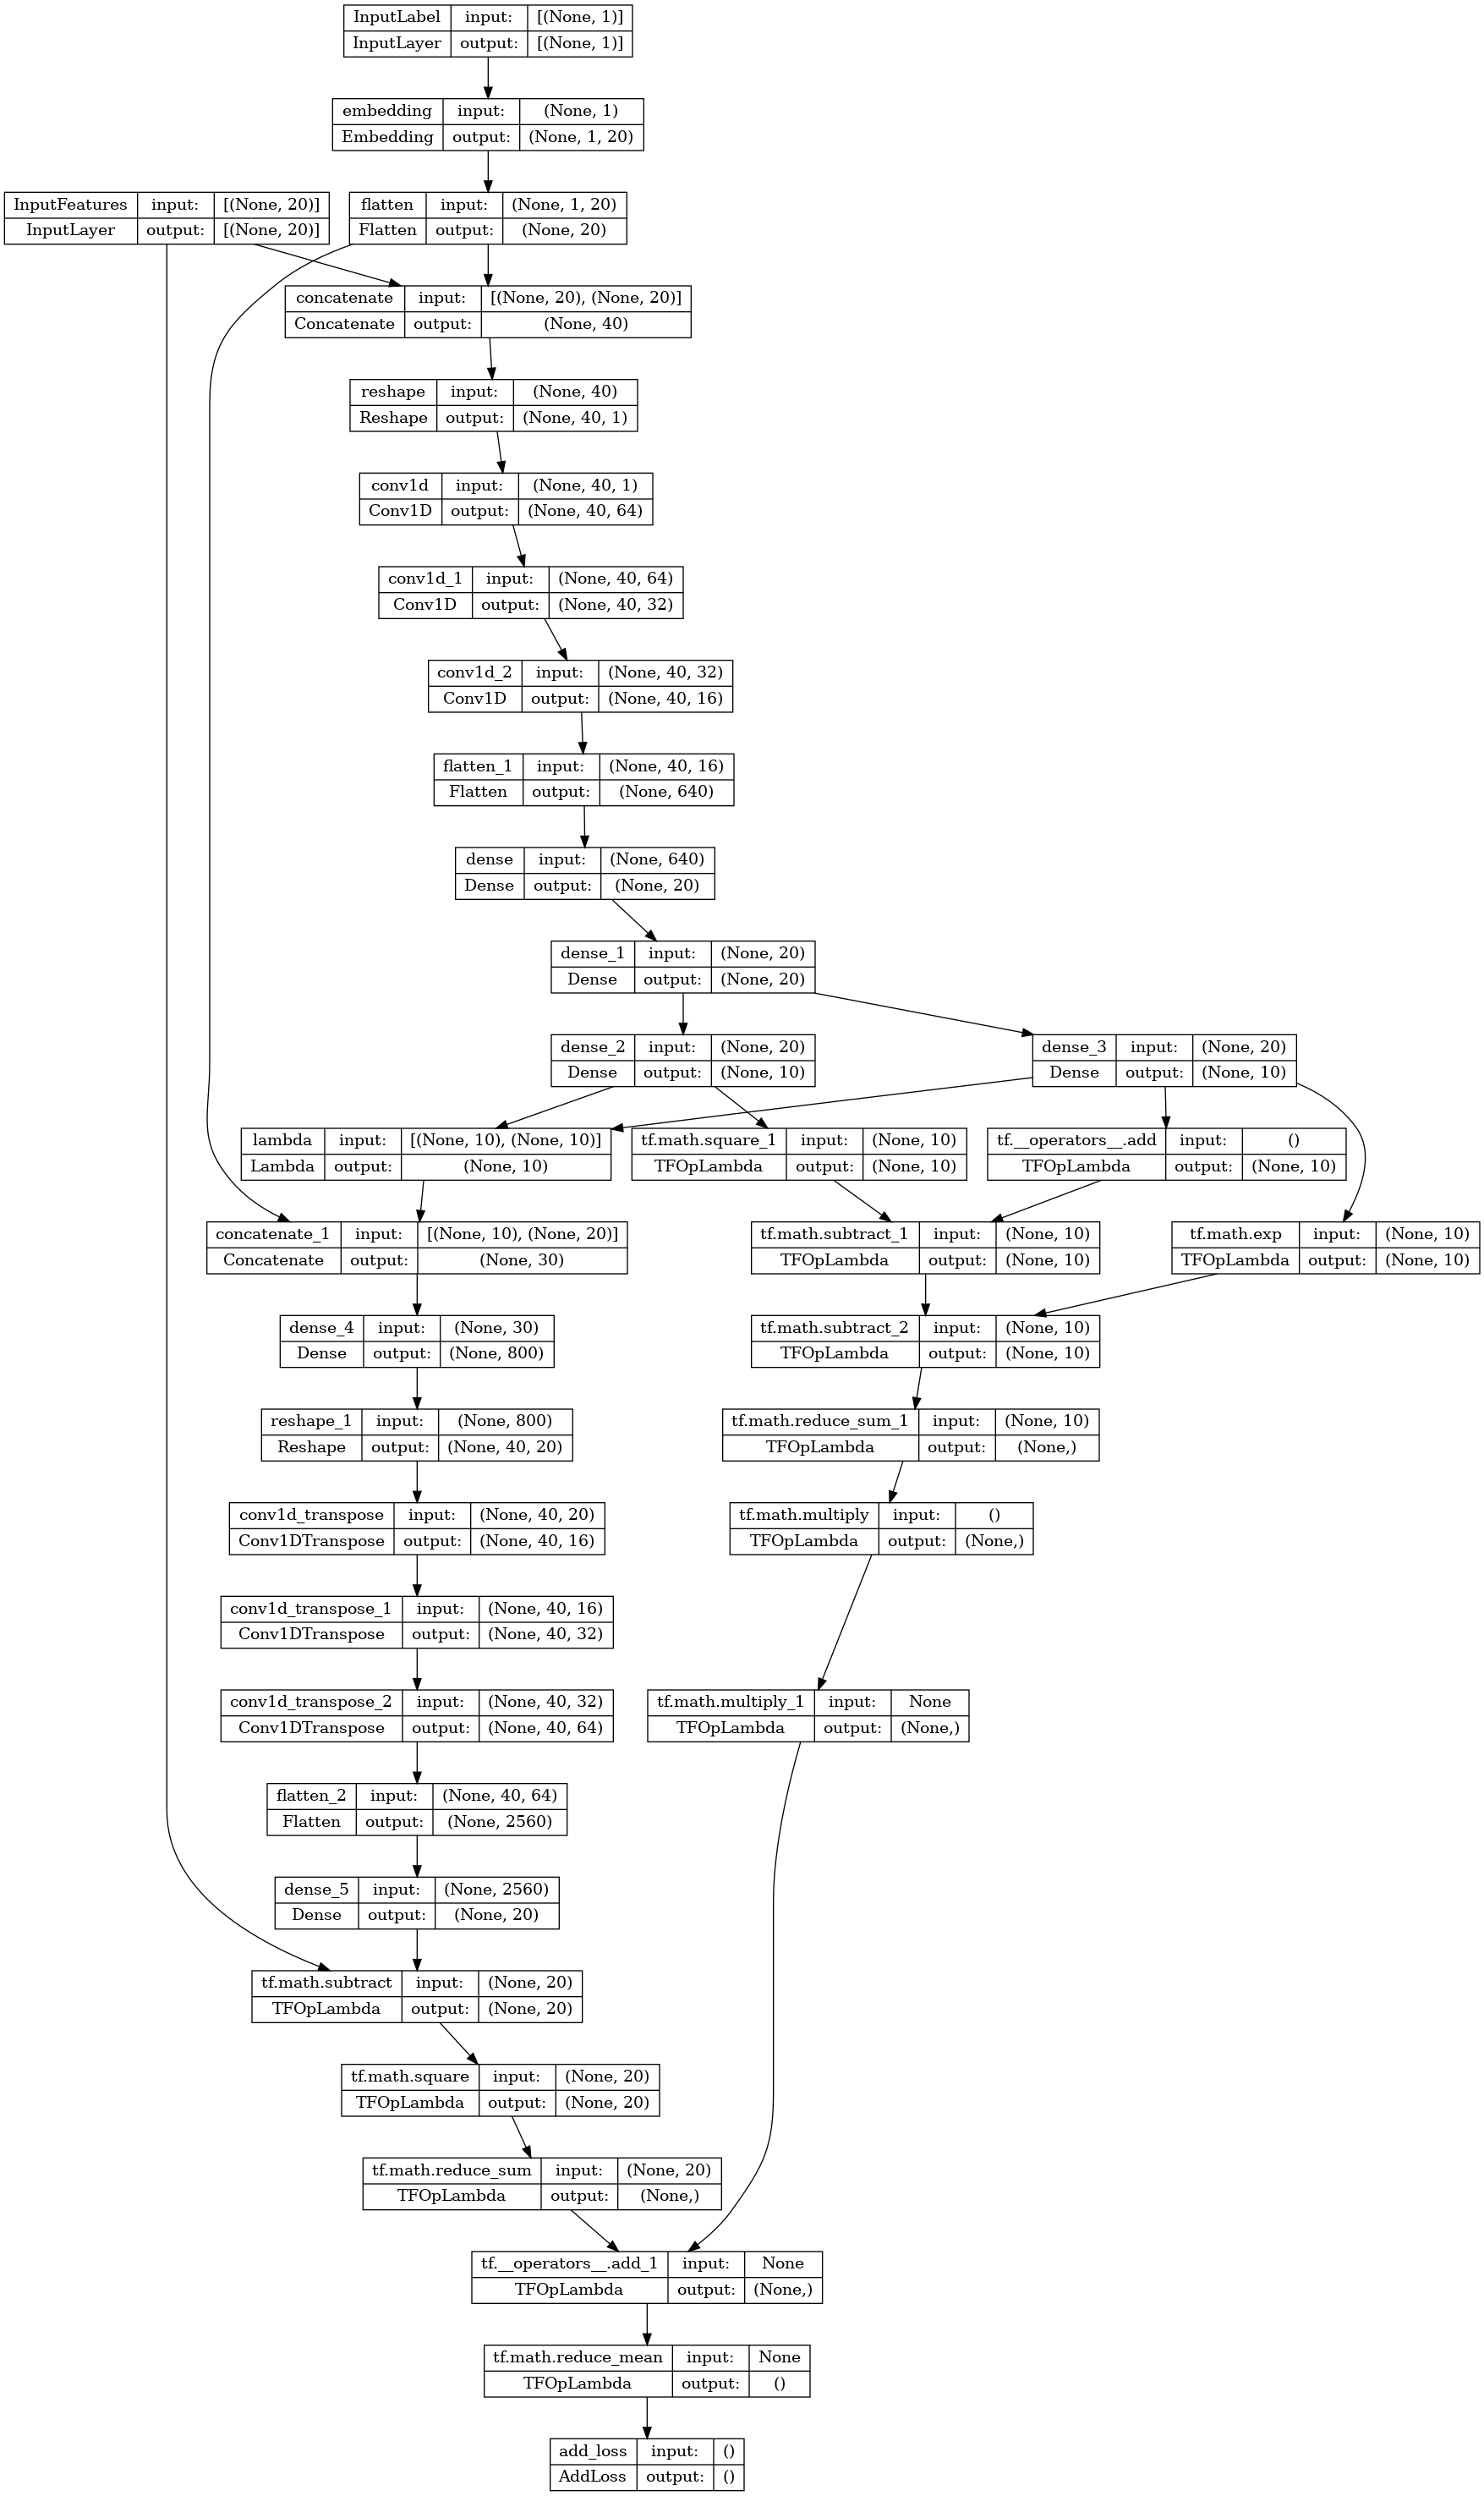

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

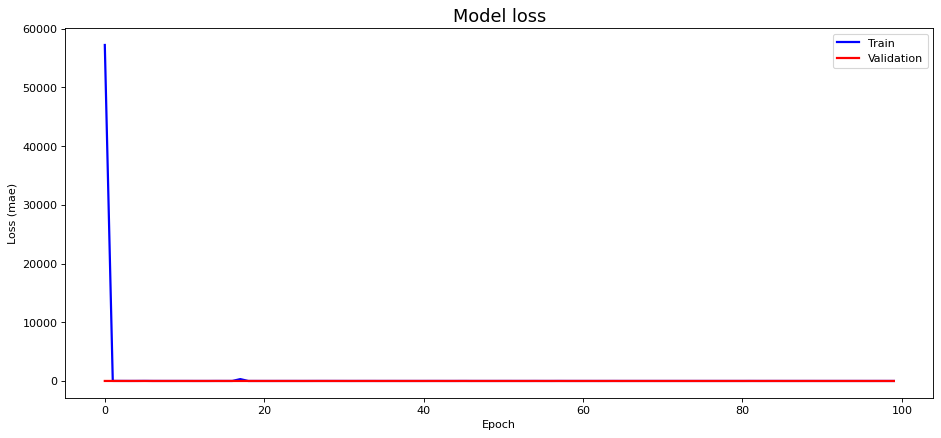

In [28]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [29]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [30]:
X_test.shape

(14852, 20)

In [31]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

465/465 [==============================] - 1s 2ms/step


In [32]:
error_df

,reconstruction_error,true_class
38166,4.428309e+02,0
122124,5.686583e+04,0
11263,1.436517e+05,0
59637,8.925293e+05,0
117914,1.890319e+01,1
...,...,...
30563,8.582387e+01,1
22532,9.462452e+06,0
125705,8.974711e-01,1
6970,5.950776e+02,0


In [33]:
error_df['true_class'].value_counts()

0    7720
1    7132
Name: true_class, dtype: int64

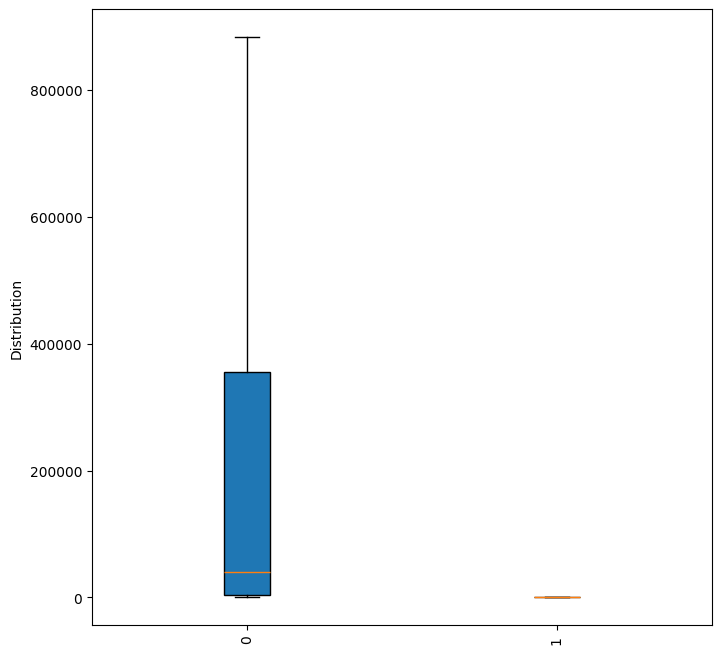

In [34]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


In [35]:
print(error_df)

        reconstruction_error  true_class
38166           4.428309e+02           0
122124          5.686583e+04           0
11263           1.436517e+05           0
59637           8.925293e+05           0
117914          1.890319e+01           1
...                      ...         ...
30563           8.582387e+01           1
22532           9.462452e+06           0
125705          8.974711e-01           1
6970            5.950776e+02           0
49983           1.503512e+02           1

[14852 rows x 2 columns]


In [36]:
# Flatten the 'true_class' column to remove the nested list structure
error_df['true_class'] = error_df['true_class'].apply(lambda x: x[0][0] if isinstance(x, list) else x)

# Ensure 'reconstruction_error' is of type float
error_df['reconstruction_error'] = error_df['reconstruction_error'].astype(float)

print(error_df)


        reconstruction_error  true_class
38166           4.428309e+02           0
122124          5.686583e+04           0
11263           1.436517e+05           0
59637           8.925293e+05           0
117914          1.890319e+01           1
...                      ...         ...
30563           8.582387e+01           1
22532           9.462452e+06           0
125705          8.974711e-01           1
6970            5.950776e+02           0
49983           1.503512e+02           1

[14852 rows x 2 columns]


In [37]:
# 그래프 보고 threshold 결정
threshold = 0.0098

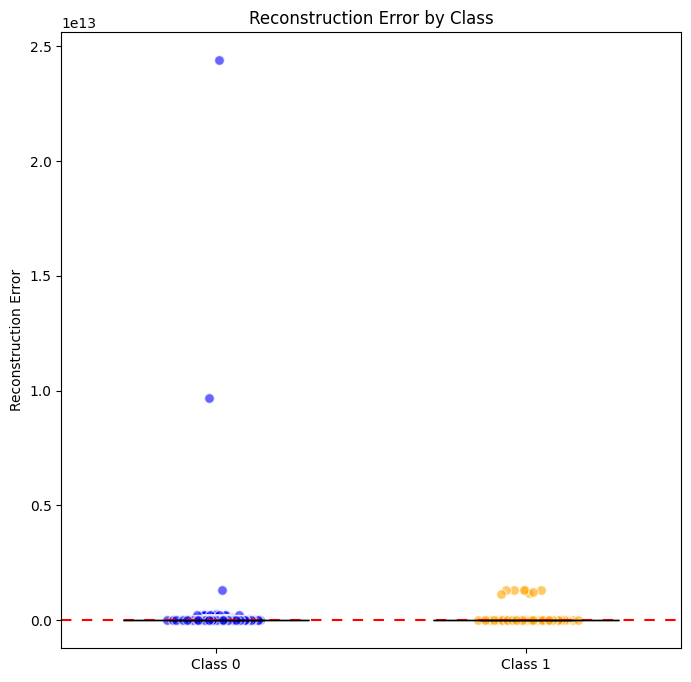

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Add jitter to x-axis for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Add jitter to x-axis for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


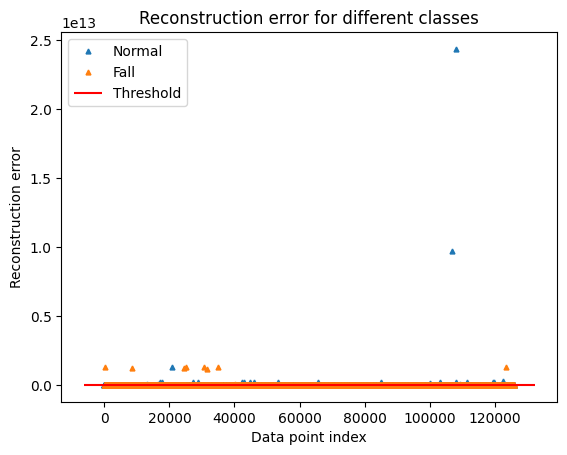

In [39]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

<Figure size 800x800 with 0 Axes>

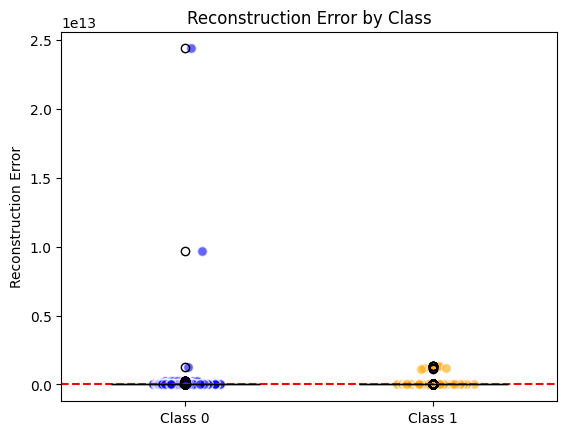

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots()

# Create a swarm plot equivalent using scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Add jitter to x-axis for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Add jitter to x-axis for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showcaps=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black', linewidth=0))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
plt.axhline(y=0.03, xmin=0.0, xmax=1.0, color='red', linestyle='--')

# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


<Figure size 1200x1200 with 0 Axes>

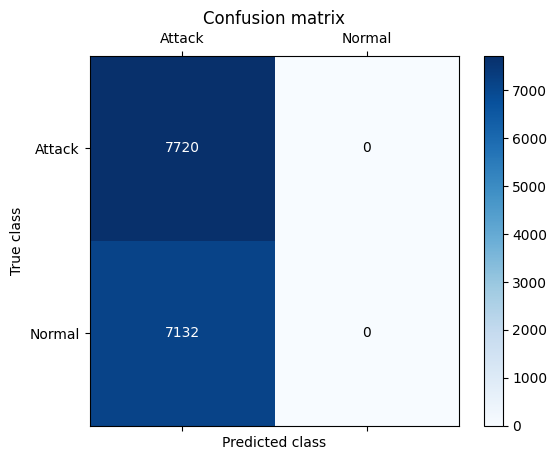

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


In [42]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.5197953137624562
Precision : 0.0
Recall : 0.0
F1 : 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


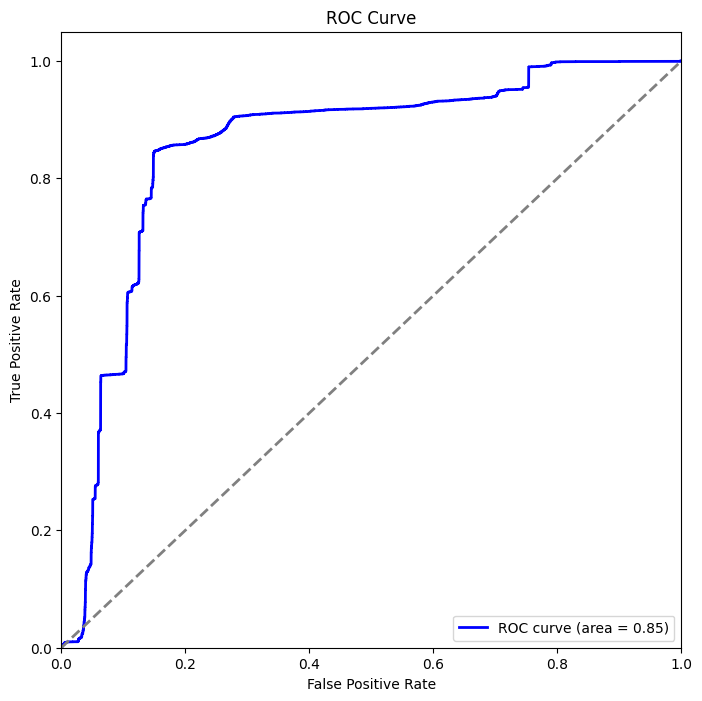

In [43]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Extract true labels and reconstruction errors from the error_df DataFrame
true_labels = error_df['true_class'].values
reconstruction_errors = error_df['reconstruction_error'].values

# Calculate FPR, TPR, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, reconstruction_errors, pos_label=0)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


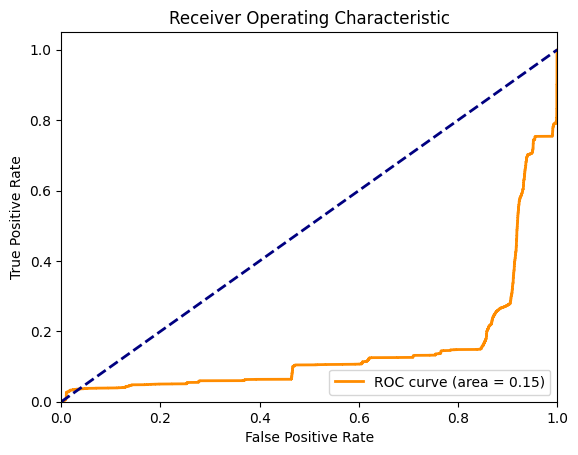

In [44]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [45]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e > threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.5197953137624562
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
